# Bleach corrections evaluation
this notebook evaluate different bleach correction methods
- single exponential fit
- double exponential fit
- different regressions (robust)

In [ ]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import preprocessing
import pynapple as nap
import seaborn as sns

from utils import * # don't 

from one.api import ONE

# one = ONE(base_url="https://alyx.internationalbrainlab.org")
one_dir = Path("/mnt/h0/kb/data/one")
one = ONE(cache_dir=one_dir)

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 166

%load_ext autoreload
%autoreload 2

In [3]:
# select and load dataset
eid = "d2c9b9c1-28e1-47db-a165-54f822ba6c30" # current working example

eid = "67231166-8980-4146-ad6d-3d7bee327ccf" # double expon
# eid = "8481a1f4-464a-4ae4-bdd0-f9ac13afa053" # current debug
eid = "619cbbfc-299a-4cdf-92ab-e81c9ef6fbfe" # not fitting exp

In [4]:
# load dataset
trials = one.load_dataset(eid, "*trials.table.pqt")

session_path = one.eid2path(eid)
regions = [reg.name for reg in session_path.joinpath('alf').glob('Region*')]

if len(regions) > 1:
    print(f"more than one regions found: {regions}")

pqt_path = session_path / 'alf' / regions[0] / 'raw_photometry.pqt'

raw_photometry = pd.read_parquet(pqt_path)

# convert to Tsd
raw_photometry = nap.TsdFrame(raw_photometry.set_index("times"))

# restricting the fluorescence data to the time within the task +-1s
t_start = trials.iloc[0]["intervals_0"] - 10
t_stop = trials.iloc[-1]["intervals_1"] + 10
session_interval = nap.IntervalSet(t_start, t_stop)
raw_photometry = raw_photometry.restrict(session_interval)

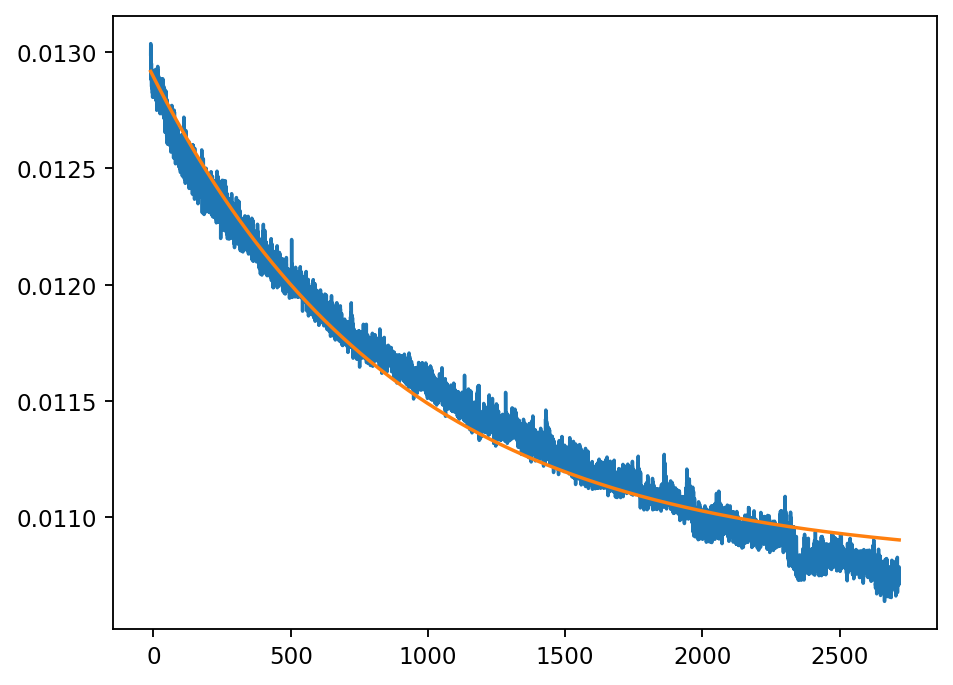

In [6]:
from bleach_corrections import BleachCorrection, ExponDecay
F = raw_photometry['raw_isosbestic']
bleach_correction = BleachCorrection(model=ExponDecay(),
                                     regression_method='mse',
                                     correction_method='subtract-divide')
bleach_correction.correct(F)

F_ref = bleach_correction.regression.predict(F.times(), return_type='pynapple')
F_corr = bleach_correction.correct(F)
fig, axes = plt.subplots()
axes.plot(F)
axes.plot(F_ref)

In [294]:
from bleach_corrections import IsosbesticCorrection, DoubleExponDecayT
fig, axes = plt.subplots()
for reg_method in ['linear','huber','irls']:
    isosbestic_correction = IsosbesticCorrection(
        regression_method=reg_method,
        correction_method='subtract-divide',
        lowpass_isosbestic=dict(N=3, Wn=0.01)
        )
    # pre bleach correct
    bc = BleachCorrection(DoubleExponDecay(), regression_method = 'irls', correction_method = 'subtract-divide')
    F_ca = bc.correct(raw_photometry['raw_calcium']) + 1
    F_iso = bc.correct(raw_photometry['raw_isosbestic']) + 1
    
    F_corr = isosbestic_correction.correct(F_ca, F_iso)
    axes.plot(F_corr, label=reg_method, lw=0.5, alpha=1.0)
axes.legend()

In [263]:
bc = BleachCorrection(DoubleExponDecay(), regression_method = 'huber', correction_method = 'subtract-divide')
F_ca = bc.correct(raw_photometry['raw_calcium']) + 5
fig, axes = plt.subplots()
axes.plot(F_ca)

/home/georg/code/ibl-photometry/src/iblphotometry/bleach_corrections.py:146: RuntimeWarning: divide by zero encountered in divide
  return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + b
/home/georg/code/ibl-photometry/src/iblphotometry/bleach_corrections.py:146: RuntimeWarning: invalid value encountered in multiply
  return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + b
